In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import feather
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import namedtuple
Path.ls = lambda x: [o.name for o in x.iterdir()]

In [3]:
# Load environment variables to get local datasets path
from dotenv import load_dotenv
load_dotenv()
data_dir = os.environ.get('datasets_path')

Load the provided excel metadata and save paths to train and validation

In [4]:
dataset_path = Path(f'{data_dir}/COVID-19-20_v2')
trn_path = dataset_path/'Train'
val_path = dataset_path/'Validation'

In [5]:
trn_volumes = pd.read_excel(dataset_path/'COVID-19-20_TrainValidation.xlsx')

# Metadata Setup

First we organize the file path information in a dataframe for easy mapping between the IDs and their segmentation mask or CT volume

In [6]:
ct_fnames = (trn_path/trn_volumes.FILENAME).astype(str) + '_ct.nii.gz'
mask_fnames = (trn_path/trn_volumes.FILENAME).astype(str) + '_seg.nii.gz'
idx = trn_volumes.FILENAME.str[18:]

In [7]:
df_meta = pd.DataFrame({'id': idx,
                        'ct_fname': ct_fnames,
                        'mask_fname': mask_fnames})

In [8]:
df_meta.head()

,id,ct_fname,mask_fname
0,391,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...
1,383_1,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...
2,338,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...
3,623,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...
4,559,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...


Assuming the `_1` or `_0` suffix on the id mean that it is either a duplicate or additional scan, we can drop the suffix and treat it as the same patient so we can keep it in the same train/validation set later on

In [9]:
df_meta['stripped_id'] = df_meta.id.str.replace('_1', '')
df_meta['stripped_id'] = df_meta.stripped_id.str.replace('_0', '')
len(df_meta.stripped_id) > len(set(df_meta.stripped_id))

False

Turns out the suffixes were not indicative of duplicates/additional scans for a patient at least for our training set

In [10]:
df_meta.drop('stripped_id', axis=1, inplace=True)

Add the metadata from the header of each CT scan to df_meta so we can perform EDA

In [46]:
def append_header_meta(df, ct_fnames, mask_fnames):
    meta_dict = {}
    fnames = zip(ct_fnames, mask_fnames)
    for _, (ct_fname, mask_fname) in tqdm(enumerate(fnames), total=len(ct_fnames)):
        ct = nib.load(ct_fname)
        mask = nib.load(mask_fname)
        hdr = ct.header
        header_cols = set(list(hdr))
        for key in header_cols:
            if hdr[key].size > 1:
                for i, value in enumerate(hdr[key]):
                    meta_dict.setdefault(f'{key}_{i}',[]).append(value)
            else:
                meta_dict.setdefault(key,[]).append(hdr[key].item())
        img = ct.get_fdata()
        img_mask = mask.get_fdata()
        meta_dict.setdefault('img_min',[]).append(img.min())
        meta_dict.setdefault('img_max',[]).append(img.max())
        meta_dict.setdefault('img_mean',[]).append(img.mean())
        meta_dict.setdefault('img_std',[]).append(img.std())
        meta_dict.setdefault('pct_lesion',[]).append(img_mask.sum() / img_mask.size)
        
    for key in meta_dict:
        df[key] = meta_dict[key]

In [47]:
append_header_meta(df_meta, df_meta.ct_fname, df_meta.mask_fname)

100%|██████████| 199/199 [01:25<00:00,  2.33it/s]


In [48]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', 30): 
    display(df_meta.head().T)

,0,1,2,3,4
id,391,383_1,338,623,559
ct_fname,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...
mask_fname,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...
slice_end,0,0,0,0,0
quatern_c,0,0,0,0,0
vox_offset,0,0,0,0,0
glmax,7321,1565,9066,3071,7964
datatype,4,4,4,4,4
intent_name,b' ',b' ',b' ',b' ',b' '
dim_info,0,0,0,0,0


Save the metadata df as feather for fast access later on

In [49]:
# df_meta.to_feather('df_meta.fth')

# EDA

In [6]:
df_meta = pd.read_feather('df_meta.fth')

## Extreme Values Check

In [32]:
# Note that nifti get_fdata() function already casts the datatype to float
index = ['bitpix','datatype']
values=['img_mean','img_std','img_max','img_min','id']
aggfunc={'img_mean':'mean', 'img_std':'mean','img_max':'max','img_min':'min','id':'count'}
df_meta.pivot_table(values=values, index=index, aggfunc=aggfunc)

,,id,img_max,img_mean,img_min,img_std
bitpix,datatype,,,,,
16,4,196,32737.0,-882.208554,-10380.0,722.671307
64,64,3,6269.0,-897.503456,-2048.0,747.075140


It is quite concerning that the range of values are so large, especially for the 16bit volumes. The range for voxels should not be so large as the relevant data usually lies within a small range of housefield units (-1000,1000). If the range is large then we need to check the distribution of pixels to see how much of the data is present in the extreme ranges.

In [79]:
def distrib_summ(t, ax):
    ax.hist(t,40)
    return np.array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

In [77]:
df_16 = df_meta.query('bitpix==16')
df_64 = df_meta.query('bitpix==64')

[ 1348  1360  1431  1569  2453 24635 31714 32663 32737]
[-10380 -10238  -9025  -6925  -2048  -1161  -1024  -1024  -1024]


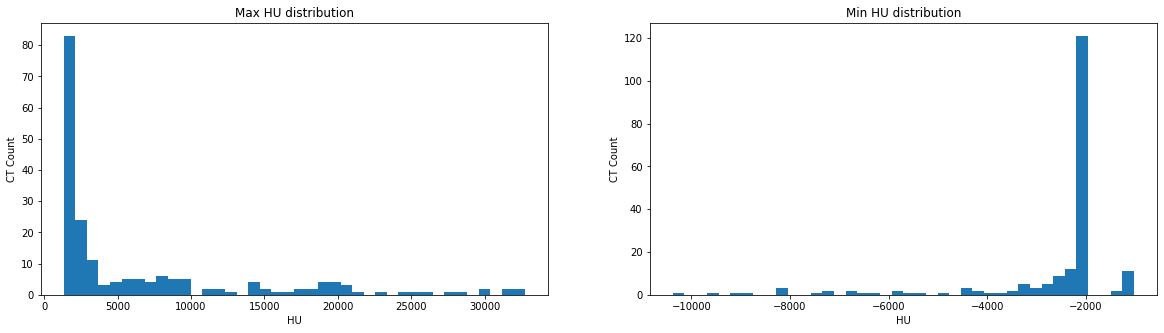

In [80]:
def plot_dists(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    axes[0].title.set_text('Max HU distribution')
    axes[1].title.set_text('Min HU distribution')
    for i in range(2):
        axes[i].set_xlabel('HU')
        axes[i].set_ylabel('CT Count')
    print(distrib_summ(df.img_max.values,axes[0]))
    print(distrib_summ(df.img_min.values,axes[1]))
plot_dists(df_16)

[2253 2253 2254 2262 2348 5876 6190 6261 6269]
[-2048 -2048 -2048 -2048 -2048 -2048 -2048 -2048 -2048]


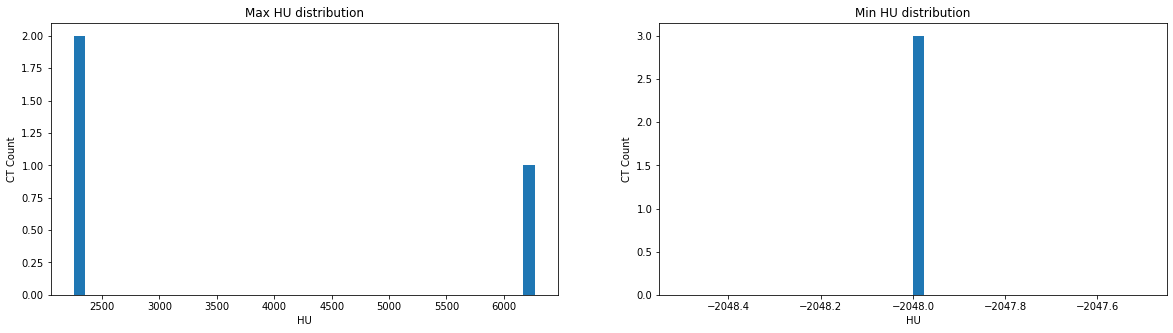

In [75]:
plot_dists(df_64)

A relevant amount of volumes have their max and min values in extreme ranges. Thankfully, the standard deviation of voxel values is roughly around 700 so we can consider cropping out the extreme values. Let us grab some examples and clip them to visualize the outcome of this.

## Visually checking the effects of clipping

In [19]:
# num CT's with max HU greater than the 95th percentile
len(df_meta[df_meta.img_max > 24635])

10

In [20]:
# grab a ct that has max HU values greater than the 95th percentile
sample_extreme_ct = nib.load(df_meta[df_meta.img_max > 24635].iloc[0].ct_fname)

In [21]:
ct_a = sample_extreme_ct.get_fdata()
ct_pos = ct_a.clip(0) # remove the negative values
ct_pos.shape

(512, 512, 91)

In [22]:
# get the slice with the most high values
z_slice= None
z_high=0.
for i in range(91):
    if ct_pos[:,:,i].sum() > z_high:
        z_high = ct_pos[:,:,i].sum()
        z_slice = ct_a[:,:,i]

In [38]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

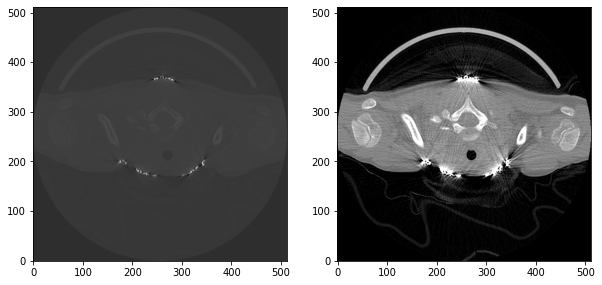

In [39]:
# Removing the extreme values makes it looking much better
show_slices([z_slice, z_slice.clip(-1000,1000)])

## Windowing

As per https://radiopaedia.org/articles/windowing-ct we will try to apply the typical windowing for chest scans

In [25]:
WindowInfo = namedtuple('WindowInfo', ['width', 'level'])

In [32]:
lung_window = WindowInfo(1500, -600)
mediastinal_window = WindowInfo(350, 50)

In [27]:
def window_image(img, window_center,window_width):
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    return img.clip(img_min, img_max)

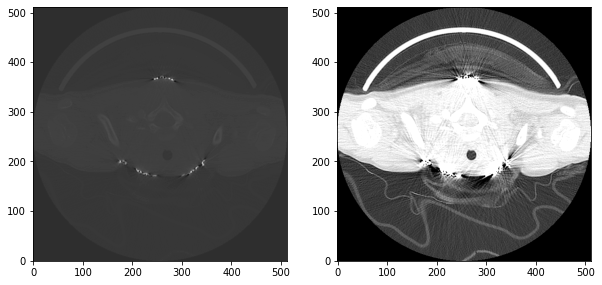

In [40]:
ct_lung = window_image(ct_a, lung_window.level, lung_window.width)
show_slices([z_slice, ct_lung[:,:,90]]) 

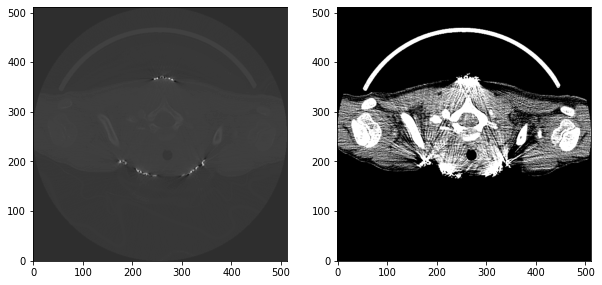

In [41]:
ct_lung = window_image(ct_a, mediastinal_window.level, mediastinal_window.width)
show_slices([z_slice, ct_lung[:,:,90]]) 

## Distribution of true positive labels

It is apparent that there is a big class imbalance between positive and negative labels. This implies that we would need to do some preprocessing to our data since if we were to simply throw data at the model then it will likely result in unstable training

count    199.000000
mean       0.437846
std        0.602369
min        0.003093
25%        0.085656
50%        0.226943
75%        0.522874
max        4.036325
Name: pct_lesion, dtype: float64

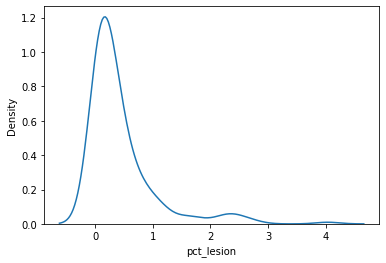

In [173]:
sns.kdeplot(data=(df_meta.pct_lesion * 100))
(df_meta.pct_lesion*100).describe()